## Exploring Image Soustraction 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import tifffile
from sklearn.cluster import KMeans
from skimage.filters.edges import binary_erosion

First we import some images to work with

In [2]:

def get_tiles_as_array(folder):
    band_list = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
    path = 'data/'+ folder
    folder_list = os.listdir(path)
    m,n = 600,1400
    array = np.zeros((m,n,len(band_list)))

    i = 0
    for band in band_list:
        for wanted_band in folder_list:
            if band in wanted_band:
                print(wanted_band)
                img = tifffile.imread(os.path.join(path,wanted_band))
                array[:,:,i] = img[:m,:n]
                i+=1
    return array

In [49]:
arrayM1 = get_tiles_as_array('Mytilene/M1')
print(arrayM1.shape)

bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12' ]
def show_array(array):
    plt.figure(figsize=(15,8*array.shape[2]))
    for i, b in zip(range(array.shape[2]), bands):
        plt.subplot(array.shape[2],1,i+1)
        plt.imshow(array[:,:,i])
        plt.xlabel(f'Bande {b}')
    plt.show
def show_image(img, title="image", cbar = True):
    plt.figure(figsize=(14,6))
    plt.imshow(img)
    plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()
    
# show_array(arrayM1)

2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B01_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B02_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B03_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B04_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B05_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B06_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B07_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B08_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B8A_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B09_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B11_(Raw).tiff
2019-06-07-00_00_2019-06-07-23_59_Sentinel-2_L2A_B12_(Raw).tiff
(600, 1400, 12)


We are going to work with the B04 image

(600, 1400)


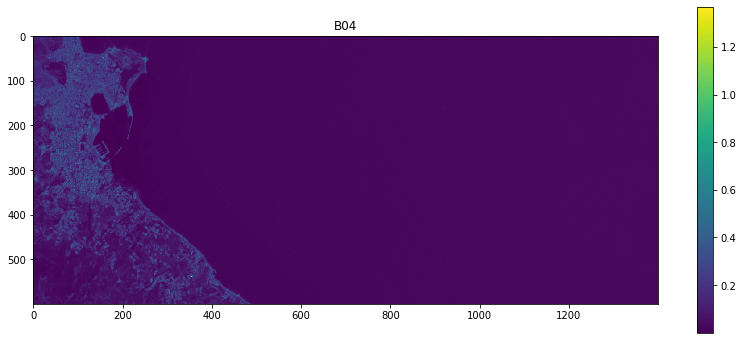

In [4]:
img = arrayM1[...,3]
print(img.shape)
show_image(img, 'B04')

Let us first display the region of interest !

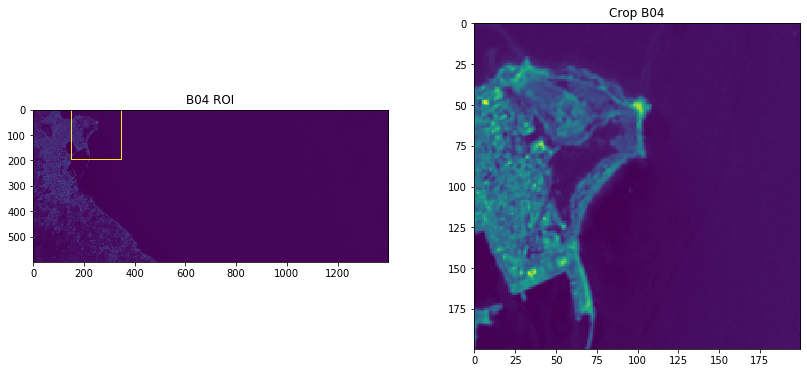

In [11]:
def mark_boundaries(img, ROI, linewidth):
    # crop the image
    crop = np.copy(img)[ROI[0][0]:ROI[1][0],ROI[0][1]:ROI[1][1]]
    # mark boudaries
    img_with_boudaries = np.copy(img)
    inside = np.copy(img_with_boudaries[ROI[0][0]+linewidth:ROI[1][0]-linewidth,ROI[0][1]+linewidth:ROI[1][1]-linewidth])
    img_with_boudaries[ROI[0][0]:ROI[1][0],ROI[0][1]:ROI[1][1]] = 2
    img_with_boudaries[ROI[0][0]+linewidth:ROI[1][0]-linewidth,ROI[0][1]+linewidth:ROI[1][1]-linewidth] = inside
    return img_with_boudaries, crop

def show_2_images(img1, img2, ttl1, ttl2):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(ttl1)
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(ttl2)
    plt.show()

ROI = [[0, 150],[200, 350]]
img_with_boudaries, crop = mark_boundaries(img, ROI, 5)
show_2_images(img_with_boudaries, crop, 'B04 ROI', 'Crop B04')

## Fist difference - Horizontal

We substract for each pixel the pixel that is directly to the right. We account for padding, so that the pixel on the right edge are either deleted or their initial value


In [6]:
def difference_h(img, padding = True):
    diff_h = img[:,:-1]-img[:,1:] if (padding==True) else img-np.concatenate((img[:,1:], np.zeros((img.shape[0],1))), axis=1)
    return diff_h

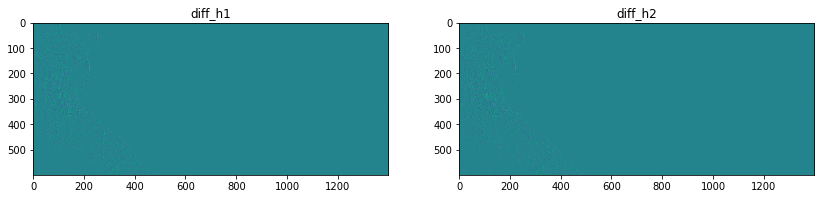

In [7]:
diff_h1 = difference_h(img, padding = True)
diff_h2 = difference_h(img, padding = False)
show_2_images(diff_h1, diff_h2, 'diff_h1', 'diff_h2')

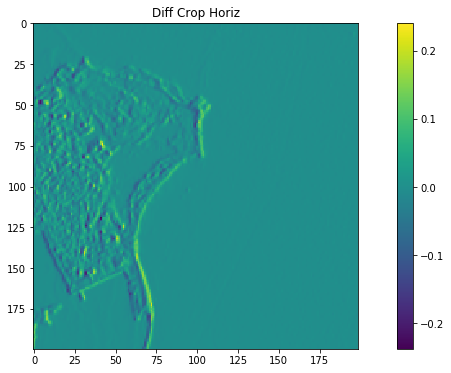

In [14]:
diff_crop_h = difference_h(crop)
show_image(diff_crop_h, 'Diff Crop Horiz')

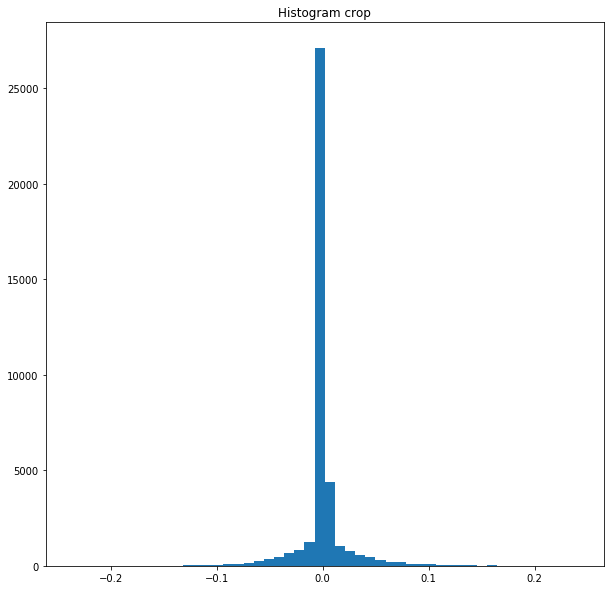

In [22]:
def plot_hist(img, bins=10, title="Histogram"):
    plt.figure(figsize=(10,10))
    plt.hist(img.flatten(), bins)
    plt.title(title)
    plt.show()

plot_hist(diff_crop_h, 50,"Histogram crop")

Let's first segment the image so that we don't have to deal with all the ground being possibly mistaken for plastic 

In [29]:
def kmeans(array, nb_clust):
    m,n = array.shape[0],array.shape[1]
    if len(array.shape)==2:
        X = array.flatten().reshape(-1, 1)
    elif len(array.shape)>2:
        array_flat = np.array([array[:,:,i].flatten() for i in range(array.shape[2])])
        X=(np.transpose(array_flat))
    kmeans = KMeans(n_clusters=nb_clust,  init='k-means++', n_init=10, max_iter=300).fit(X)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    img_labels = labels.reshape(m,n)
    return img_labels, inertia

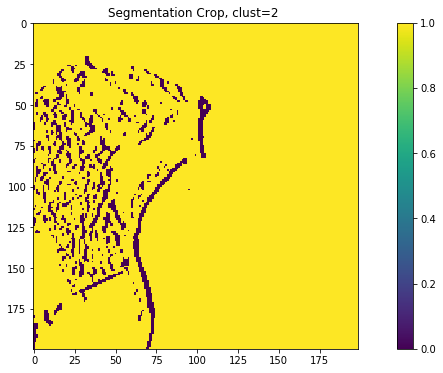

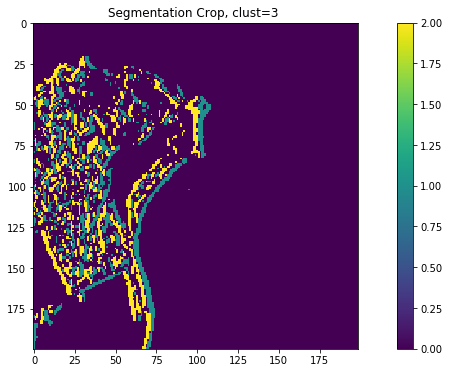

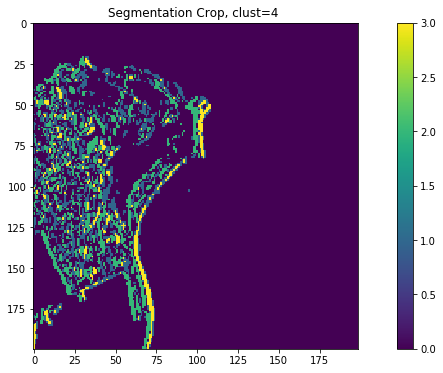

In [31]:
for nb_clust in range(2,5):
    seg_crop, inertia = kmeans(diff_crop_h,nb_clust)
    show_image(seg_crop, f'Segmentation Crop, clust={nb_clust} ')

First we do the segmentation and then we do the differnece and such, cause results here are as expected with the order we chose.

Fisrt Segmentation


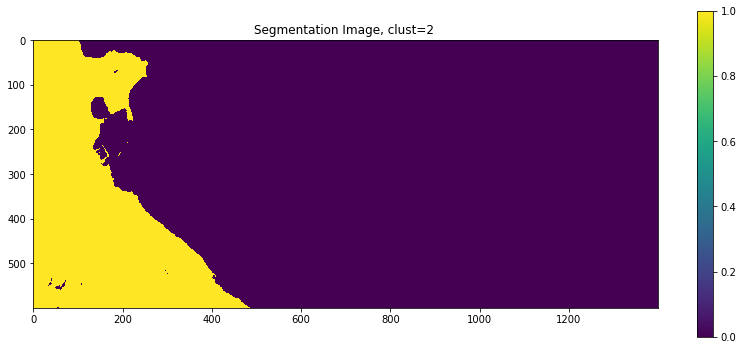

Then remove the ground, to only keep the ocean


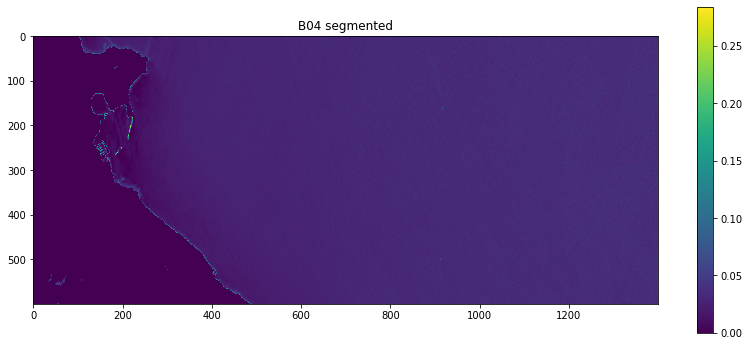

In [40]:
seg_img, inertia = kmeans(arrayM1,2)
print("Fisrt Segmentation")
show_image(seg_img, f'Segmentation Image, clust={2} ')
print("Then remove the ground, to only keep the ocean")
arrayM1_ocean = np.copy(arrayM1)
arrayM1_ocean[seg_img==1]=0
img_o = arrayM1_ocean[...,3]
show_image(img_o, 'B04 segmented')

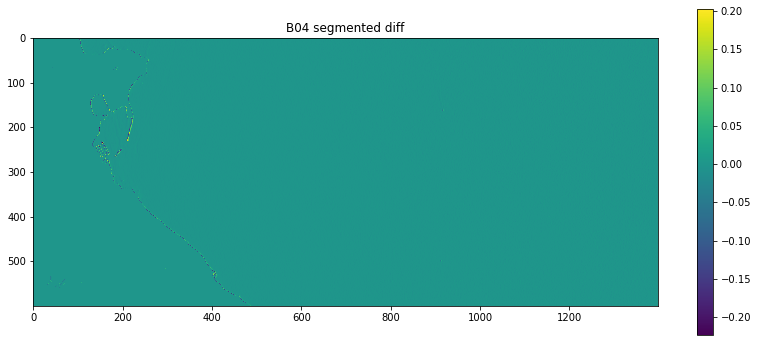

In [41]:
diff_h_o = difference_h(img_o, padding = True)
show_image(diff_h_o, 'B04 segmented diff')

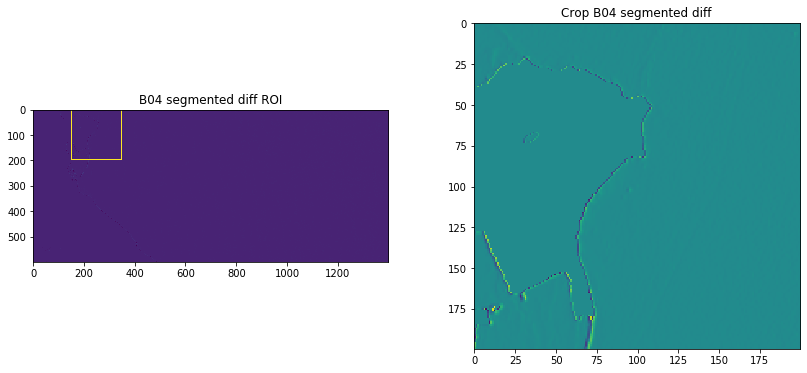

In [42]:
ROI = [[0, 150],[200, 350]]
img_with_boudaries, crop = mark_boundaries(diff_h_o, ROI, 5)
show_2_images(img_with_boudaries, crop, 'B04 segmented diff ROI', 'Crop B04 segmented diff')

real need to deal with the edges. We try to use binary erosion on the segmented image

Fisrt Segmentation


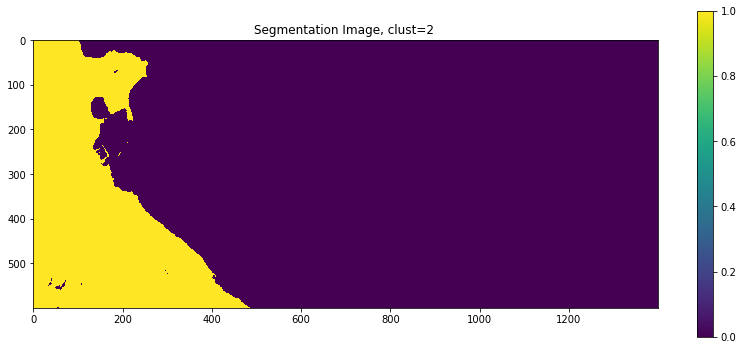

In [52]:
seg_img, inertia = kmeans(arrayM1,2)
print("Fisrt Segmentation")
show_image(seg_img, f'Segmentation Image, clust={2} ')


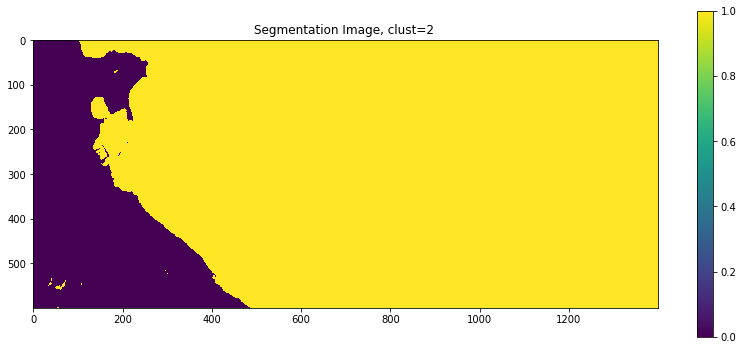

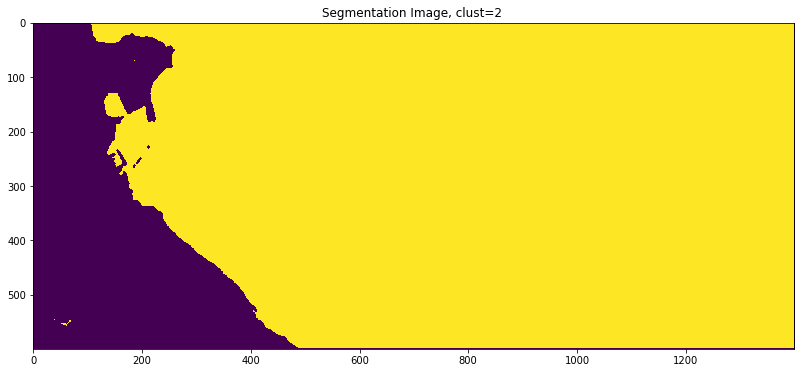

In [53]:
# ensure that the ocean is 1 in our case for the binary erosion
seg_img = 1-seg_img
show_image(seg_img, f'Segmentation Image, clust={2} ')
new_seg_image = binary_erosion(seg_img, iterations=2)
show_image(new_seg_image, f'Segmentation Image, clust={2} ', cbar=False)



Then remove the ground, to only keep the ocean


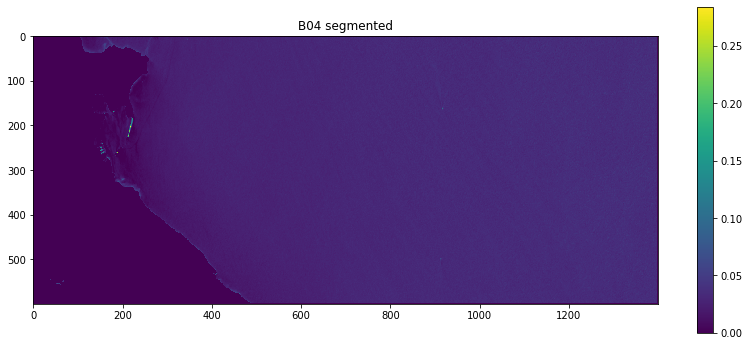

In [55]:
print("Then remove the ground, to only keep the ocean")
arrayM1_ocean = np.copy(arrayM1)
arrayM1_ocean[new_seg_image==0]=0
img_o = arrayM1_ocean[...,3]
show_image(img_o, 'B04 segmented')

## Second difference - Vertical

In [15]:
def difference_v(img, padding = True):
    diff_v = img[:-1,:]-img[1:,:] if (padding==True) else img-np.concatenate((img[1:,:], np.zeros((1,img.shape[1]))), axis=0)
    return diff_v

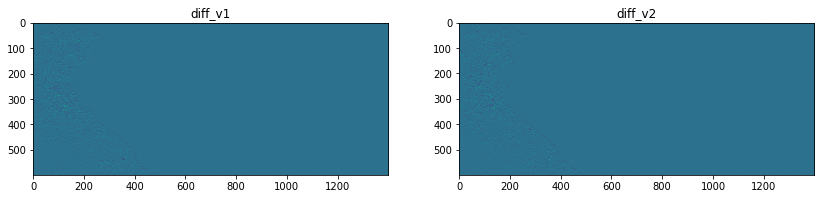

In [16]:
diff_v1 = difference_v(img, padding = True)
diff_v2 = difference_v(img, padding = False)
show_2_images(diff_v1, diff_v2, 'diff_v1', 'diff_v2')

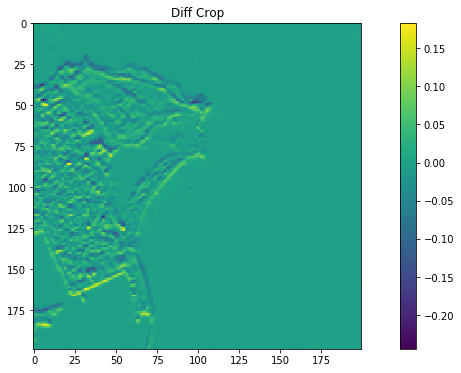

In [17]:
diff_crop_v = difference_v(crop)
show_image(diff_crop_v, 'Diff Crop')